# Particle trajectories reconstruction


When particles collide inside the LHC, billions sub-particles are produced in all directions. The tracking detector measures the energy deposited by these sub-particle when hitting the detector material. So for each particles traversing the detector we get its impact points (10 points on average). 

The challenge is to reconstruct the particles trajectories from these 3D points.



This notebook shows simple steps to: 

    -load an event data stored in %path2data
    -Visualize hits in R,Z 
    -Apply pre-clustering with K-means and a simple cosine hierarchical clustering (scipy)
    -Score the obtained solution online 
    -Store the solution according to the format provided
    -Load it again and score it with a simple score and with the 3D physics metric
    -Does all the previous steps for multiple events

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import  linkage, fcluster
import sys; sys.path.append('../../')
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
import trackml.dataset

from trackml.weights import print_order_weight_matrix, weight_hits

from scoring.score import score_dataset
prefix="event000000000"
#path to events data : truth,particles, hits
path2data='../../example_standard/dataset/'
#Multiple event demo , consider N events
N=2
#subset of hit
N_hits_viz=1000

## 1) Reading the dataset

In [2]:
hits, particles, truth=trackml.dataset.load_event(path2data+prefix)
# glimpse on the data
hits.head()

hit_id  volume_id  layer_id  module_id        x         y       z  ncells  \
0       1          7         2          1 -43.4647  1.068090 -1502.5       1   
1       2          7         2          1 -34.9117  4.951120 -1502.5       1   
2       3          7         2          1 -85.3878 -8.249880 -1502.5       1   
3       4          7         2          1 -52.7616  0.185945 -1502.5       1   
4       5          7         2          1 -57.5247 -3.279880 -1502.5       4   

                                              pixels  
0                              [[78, 235, 0.294737]]  
1                               [[14, 78, 0.308501]]  
2                             [[198, 991, 0.308572]]  
3                              [[81, 401, 0.310586]]  
4  [[143, 489, 0.0117284], [143, 490, 0.183647], ...

In [3]:
particles.head()

particle_id        vx        vy       vz         px         py  \
0  4503668346847232 -0.003457  0.017477 -2.25272 -12.091300  21.592199   
1  4503737066323968 -0.003457  0.017477 -2.25272  -3.098720   5.255000   
2  4503805785800704 -0.003457  0.017477 -2.25272  -0.259363  -0.123834   
3  4503874505277440 -0.003457  0.017477 -2.25272  -0.613183  -0.561883   
4  4503943224754176 -0.003457  0.017477 -2.25272   0.087379  -0.303243   

            pz  q  
0     0.343657  1  
1    -1.043440 -1  
2   -99.657997 -1  
3  -507.556000  1  
4 -1842.650024  1

In [4]:
truth.head()

hit_id         particle_id         tx        ty      tz            tpx  \
0       1  598979781232427008 -43.445801  1.067640 -1502.5      -0.613563   
1       2  702562984978808832 -34.891201  4.968270 -1502.5      -0.561645   
2       3  193658632267628544 -85.380997 -8.252040 -1502.5      -0.187750   
3       4  810653224326397952 -52.764599  0.184729 -1502.5      -0.513252   
4       5                   0 -57.519299 -3.284440 -1502.5 -266450.000000   

             tpy            tpz  
0       0.000950     -21.255301  
1       0.087538     -24.228201  
2      -0.044916      -3.366270  
3      -0.012016     -14.617400  
4  210104.000000 -940670.000000

In [3]:
# keep only most useful information
df_data=pd.merge(hits[["hit_id","x","y","z"]], truth[["hit_id","particle_id"]], on =['hit_id']) 
df_data.head()

hit_id        x         y       z         particle_id
0       1 -43.4647  1.068090 -1502.5  598979781232427008
1       2 -34.9117  4.951120 -1502.5  702562984978808832
2       3 -85.3878 -8.249880 -1502.5  193658632267628544
3       4 -52.7616  0.185945 -1502.5  810653224326397952
4       5 -57.5247 -3.279880 -1502.5                   0

In [4]:
# add r
df_data['r'] = np.hypot(df_data['x'],df_data['y'])

df_data.head()

hit_id        x         y       z         particle_id          r
0       1 -43.4647  1.068090 -1502.5  598979781232427008  43.477821
1       2 -34.9117  4.951120 -1502.5  702562984978808832  35.261032
2       3 -85.3878 -8.249880 -1502.5  193658632267628544  85.785412
3       4 -52.7616  0.185945 -1502.5  810653224326397952  52.761928
4       5 -57.5247 -3.279880 -1502.5                   0  57.618128

### Visualizing a subset of the hits

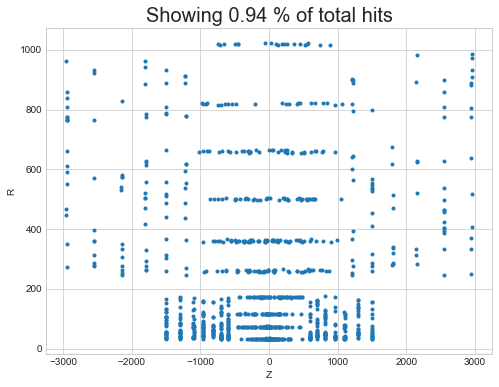

In [7]:
import seaborn as sns  #for nice plots
import matplotlib.pyplot as plt
sns.set_style("whitegrid")


import random #to select randomly subset of hits (for easier visualisation)
df_plot = df_data.sample(N_hits_viz)

fig = plt.figure(figsize=(8,6))

plt.plot(df_plot.z,df_plot.r,".")
plt.xlabel("Z")
plt.ylabel("R")
plt.title("Showing "+str(round(100*len(df_plot)/float(len(hits)),2))+" % of total hits",fontsize=20)
plt.show()


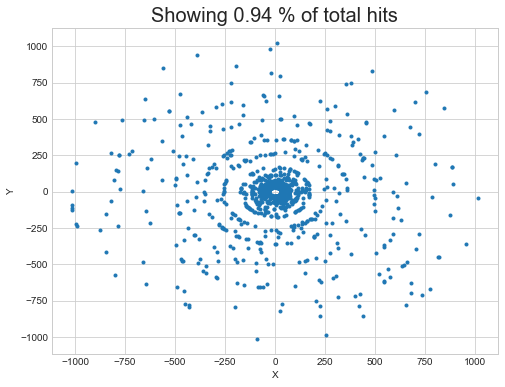

In [8]:
fig = plt.figure(figsize=(8,6))
plt.plot(df_plot.x,df_plot.y,".")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Showing "+str(round(100*len(df_plot)/float(len(hits)),2))+" % of total hits",fontsize=20)
plt.show()

<IPython.core.display.Javascript object>


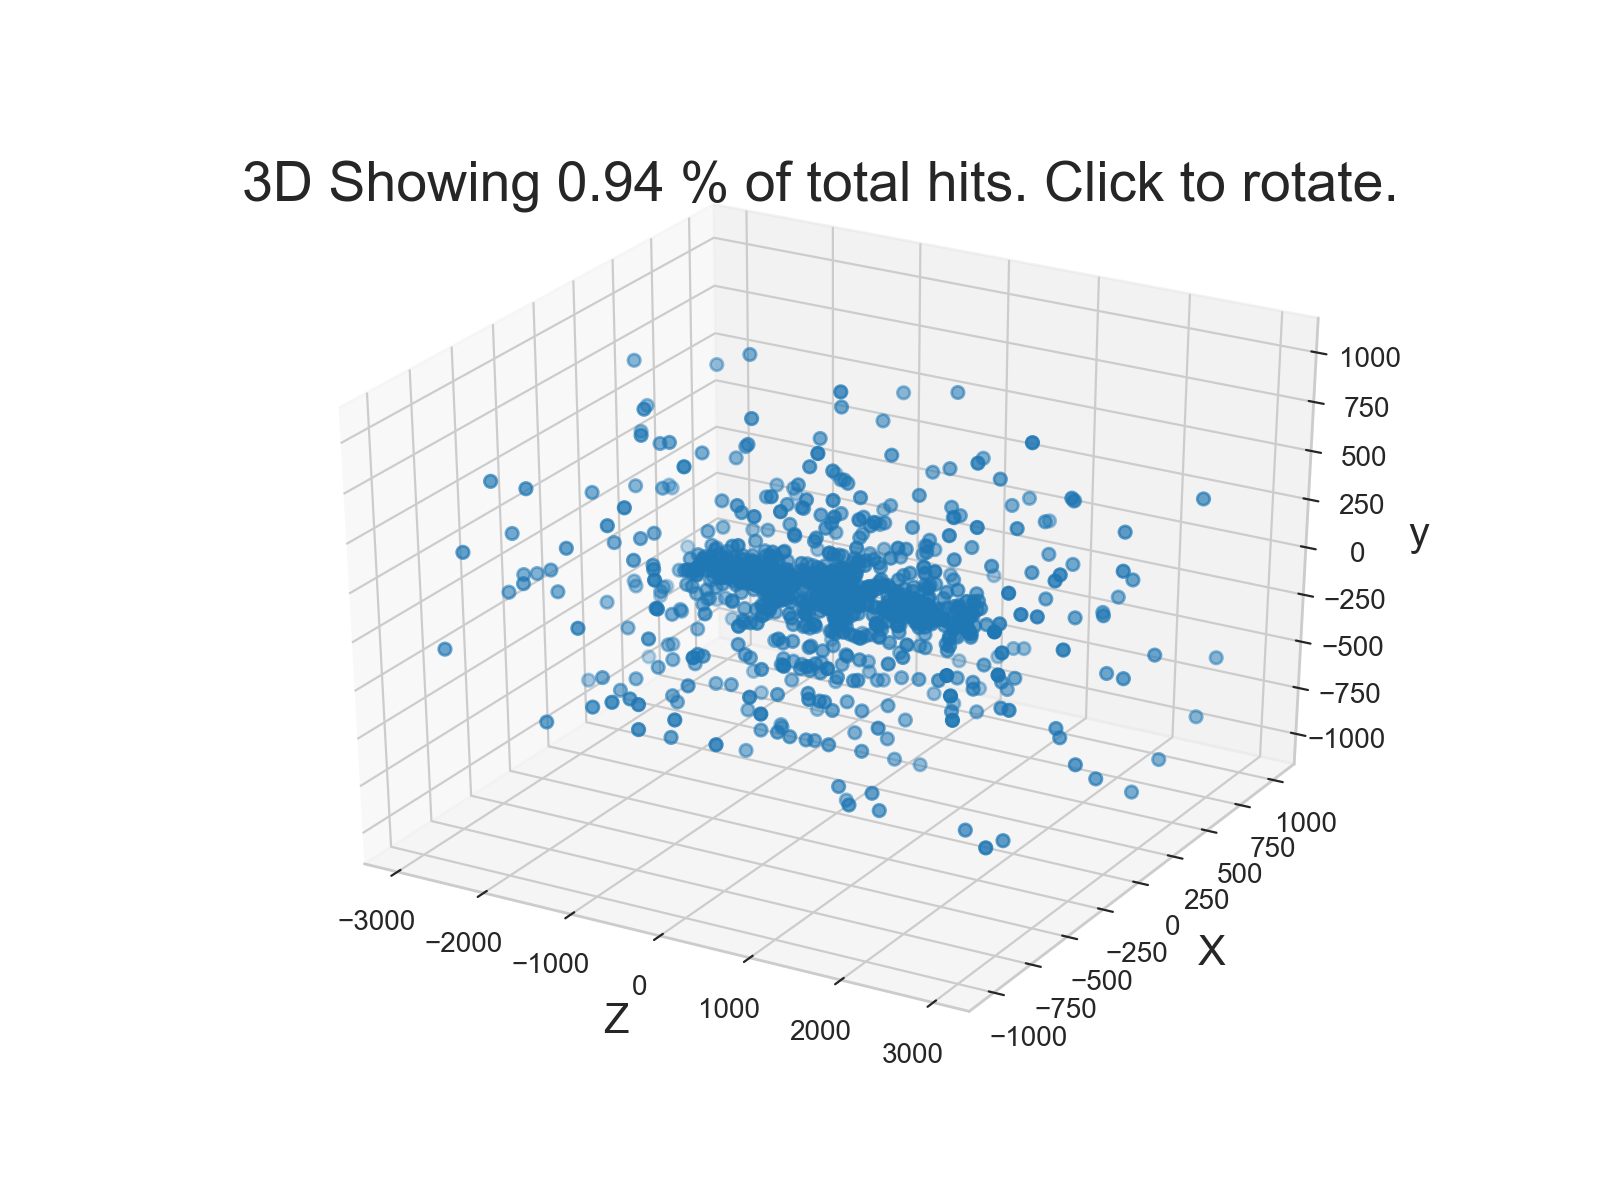

In [9]:
#3D plots
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
df_plot.head()

#DR ax.plot(df_plot.z,df_plot.y,df_plot.x,".")
ax.scatter(df_plot.z,df_plot.x,df_plot.y,".")


ax.set_xlabel('Z',fontsize=15)
ax.set_ylabel('X',fontsize=15)
ax.set_zlabel('y',fontsize=15)
plt.title("3D Showing "+str(round(100*len(df_plot)/float(len(hits)),2))+" % of total hits. Click to rotate.",fontsize=20)

plt.show()

##### Dividing the search space
We can see the hits occupy very sparse area of the detector and by definition particles occupy a much clustered/smaller area. 
To speed up the reconstruction and focalize our algorithm on smaller research space we divide the detector into N regions


## 2) Pre- Clustering : Dividing the 3D space  of one event
This step divides the dataset into N_pre_cluster regions. The pre-clustering is done with K-means

In [5]:
N_pre_cluster=5  #Less than 5 pre-clusters will crash the agglomerative clustering
#pre_labels = KMeans(n_clusters=N_pre_cluster).fit_predict(list(df_data.ix[:,["r","z"]].values))
pre_labels = KMeans(n_clusters=N_pre_cluster).fit_predict(list(df_data[["r","z"]].values))




#### Visualizing the divided space

<IPython.core.display.Javascript object>


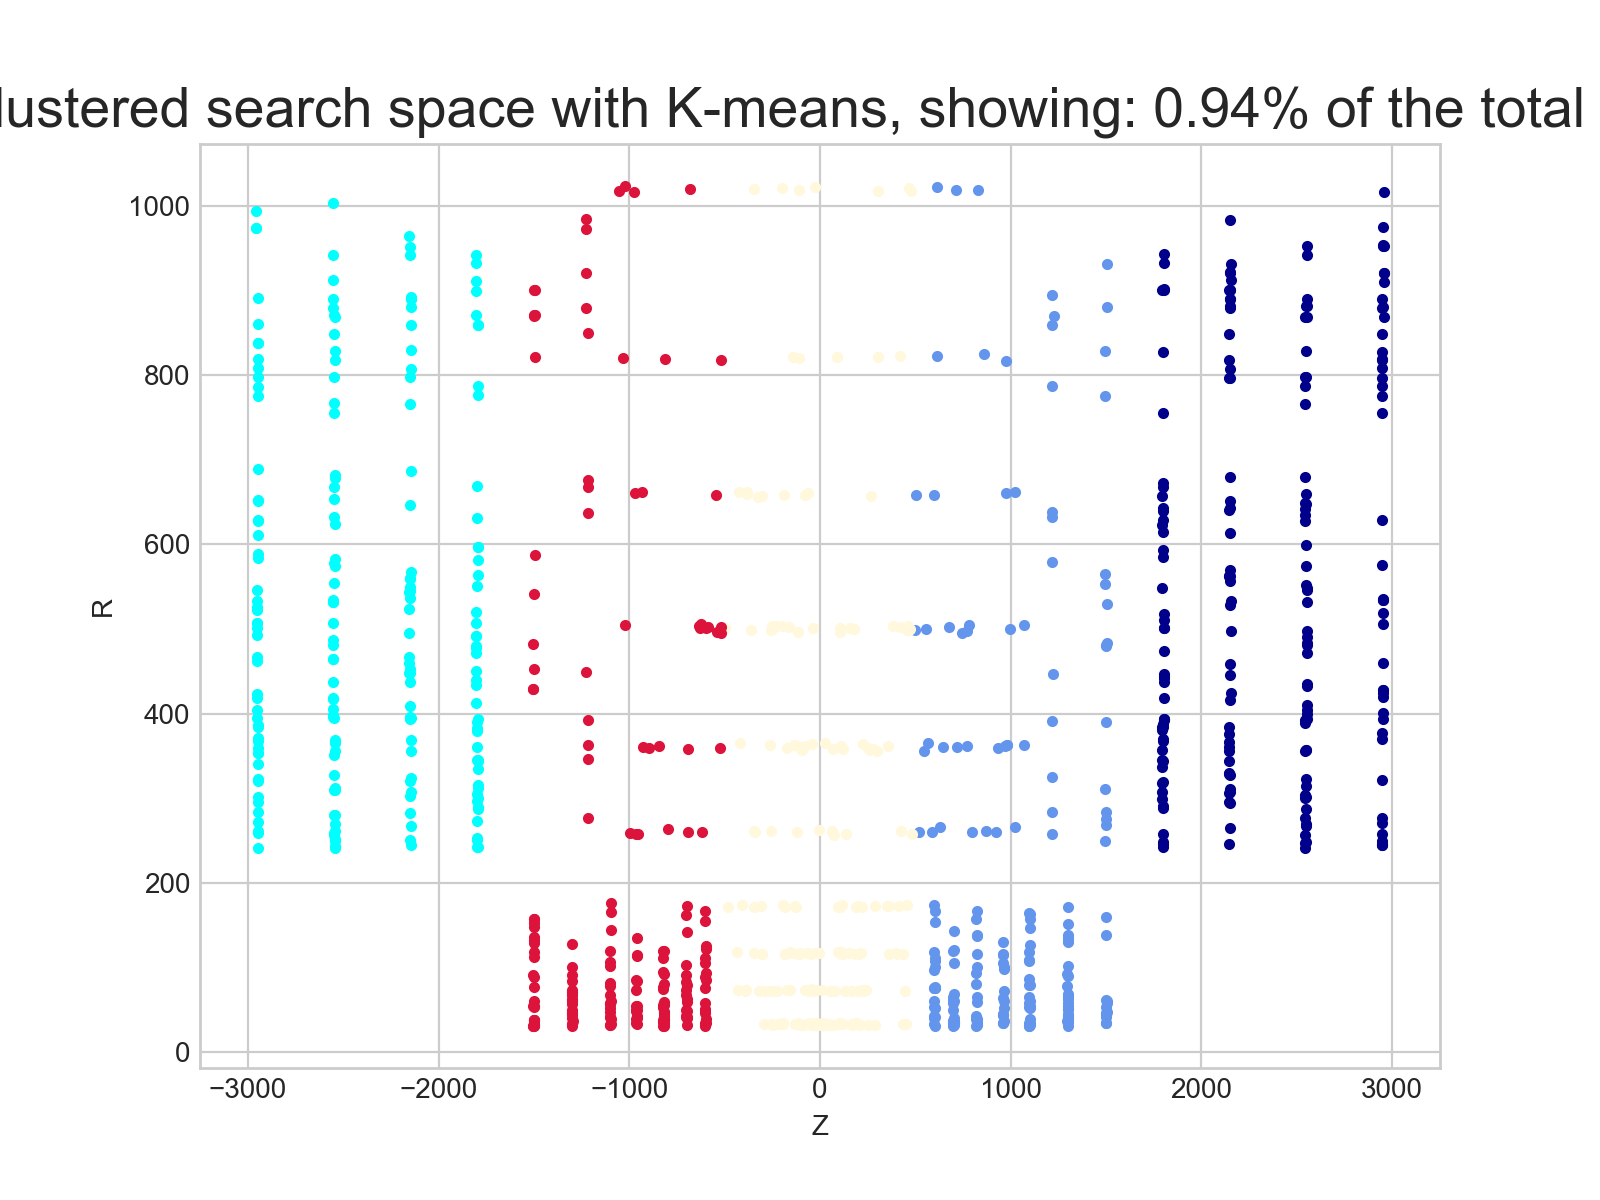

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


In [11]:
R_viz=1000
from matplotlib import colors as mcolors # for colors
colors = list(mcolors.CSS4_COLORS.keys())
from_each_reg=int(R_viz/N_pre_cluster) #show only a portion of found regions
fig = plt.figure(figsize=(8,6))

for i in range(N_pre_cluster):
    reg_i=random.sample(list(np.where(pre_labels==i)[0]), from_each_reg)
    df_plot=df_data.ix[reg_i]
    plt.plot(df_plot.z,df_plot.r,".",c=colors[17+i])
plt.xlabel("Z")
plt.ylabel("R")
plt.title("Clustered search space with K-means, showing: "+str(round(100*N_pre_cluster*from_each_reg/float(len(df_data.hit_id.values)),2))+"% of the total hits",fontsize=20)
plt.show()


<IPython.core.display.Javascript object>


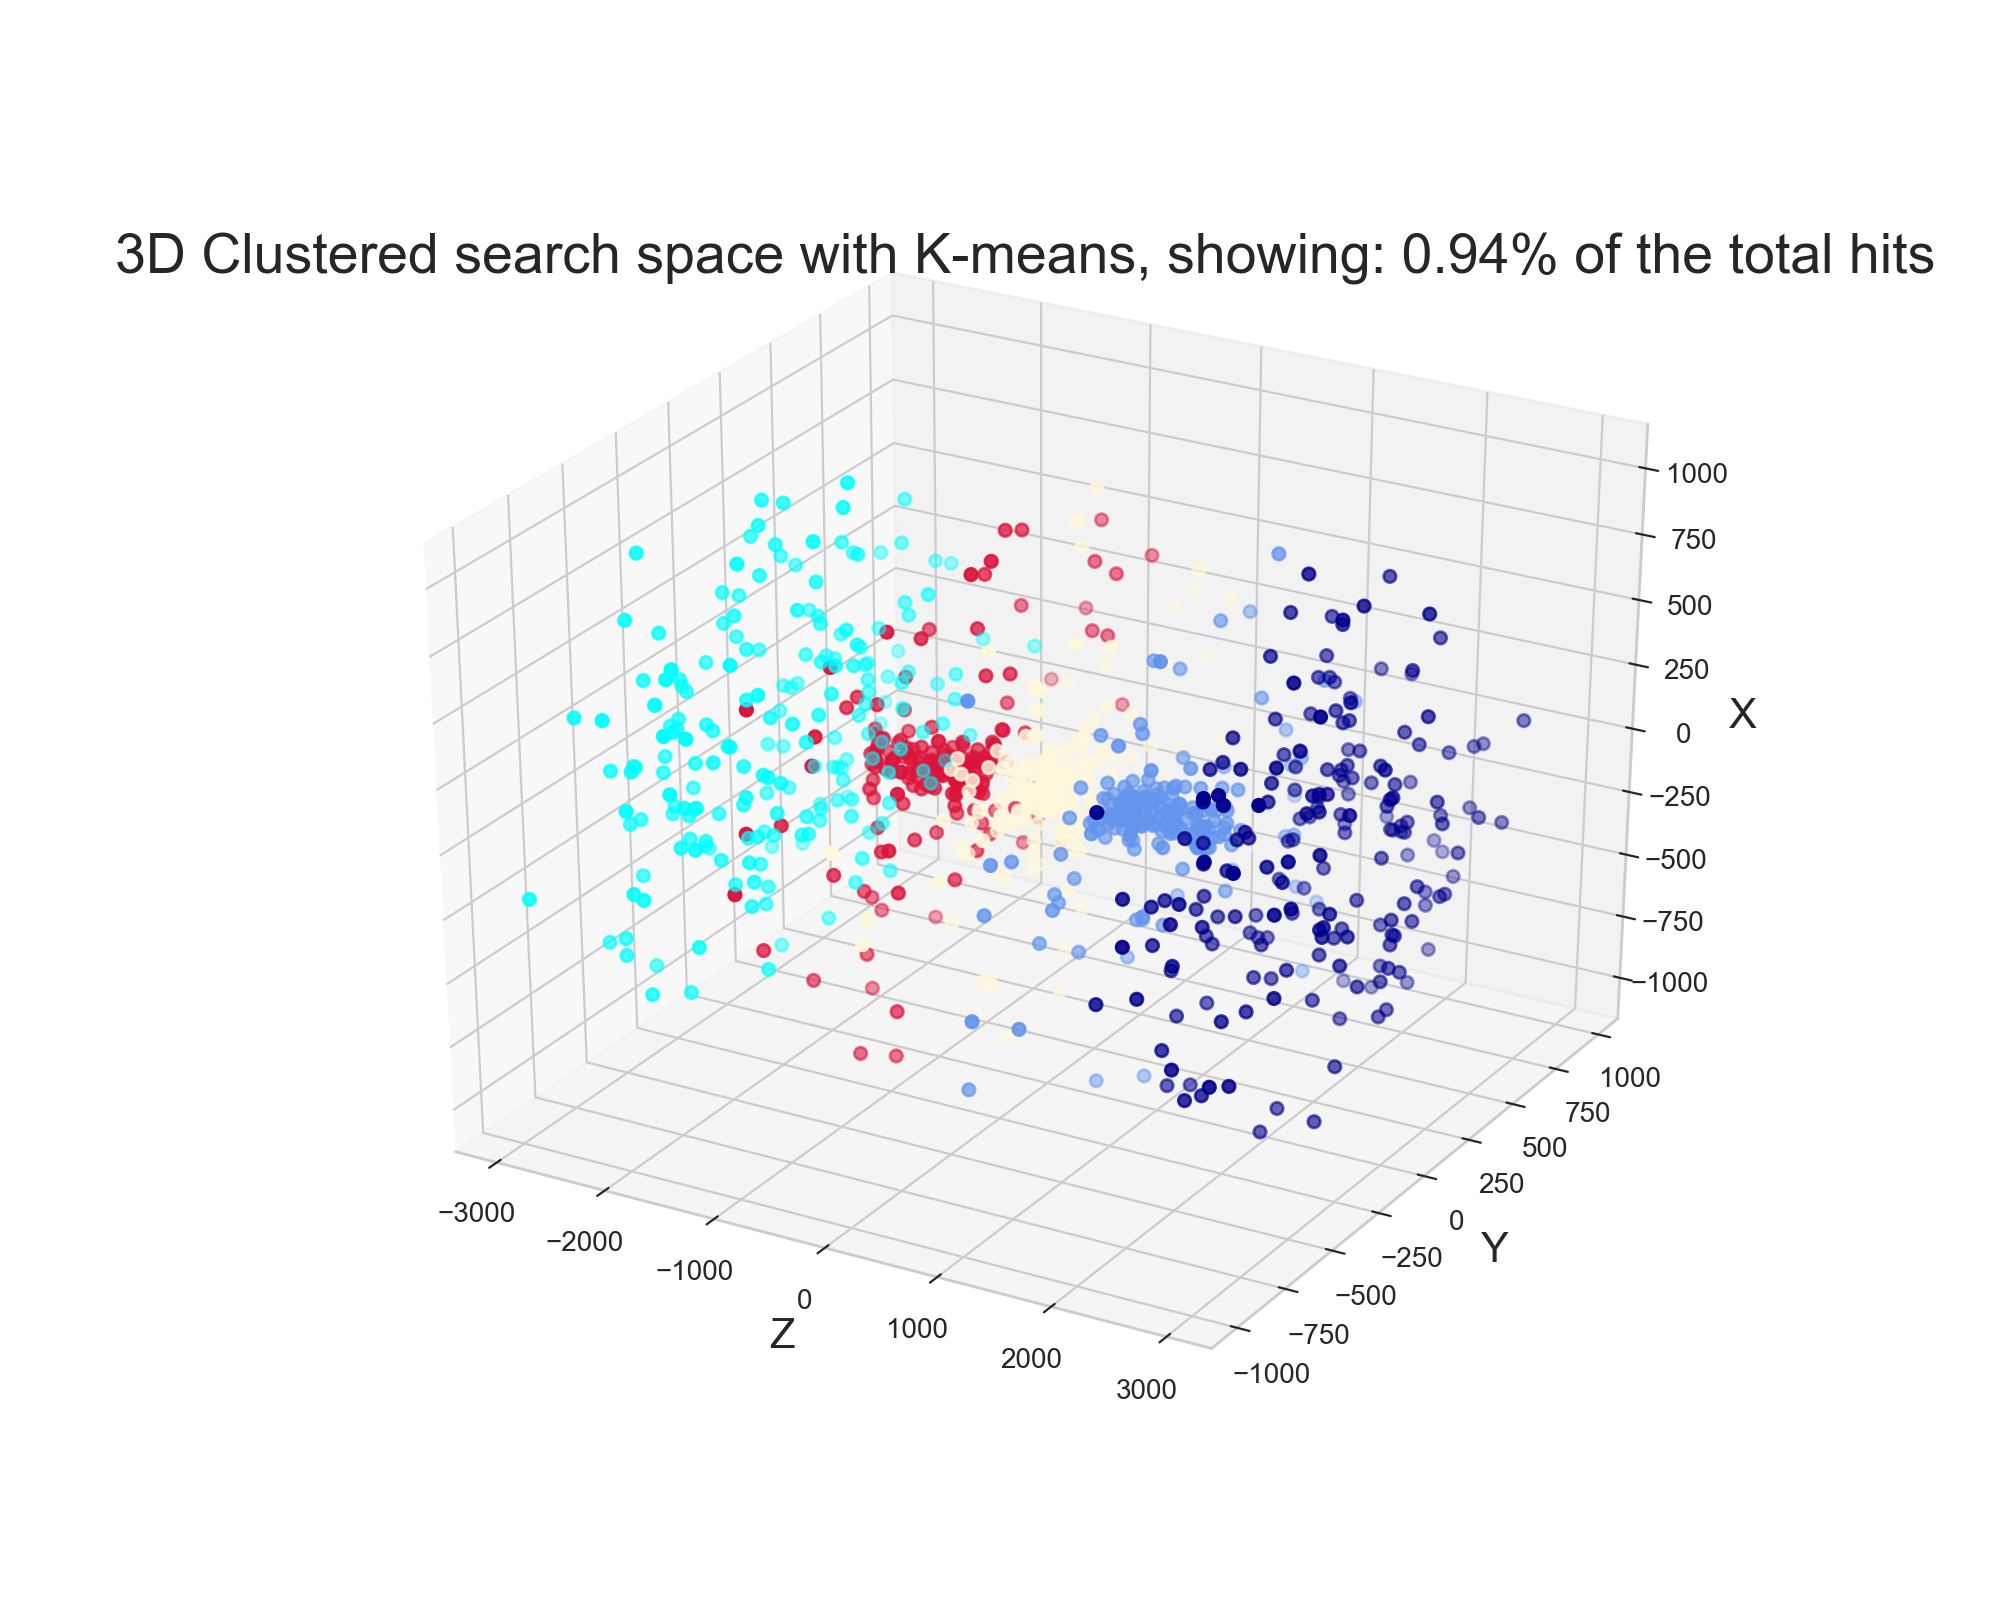

In [12]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

for i in range(N_pre_cluster):
    reg_i=random.sample(list(np.where(pre_labels==i)[0]), from_each_reg)
    df_plot=df_data.ix[reg_i]
    ax.scatter(df_plot.z,df_plot.y,df_plot.x,".",c=colors[17+i])

ax.set_xlabel('Z',fontsize=15)
ax.set_ylabel('Y',fontsize=15)
ax.set_zlabel('X',fontsize=15)

plt.title("3D Clustered search space with K-means, showing: "+str(round(100*N_pre_cluster*from_each_reg/float(len(df_data.hit_id.values)),2))+"% of the total hits",fontsize=20)
plt.show()


The pre-clustering can be customized to select any shapes from the detector space. With this simplest (R,Z) clustering we are likely to miss parts of particles across boundaries of colored region. 

## 3) Clustering one event

Actual pair-wise clustering using a cosine metric. This step produces tracks in each space region and assemble them into global labels.
Depending on the cut distance we choose, the reco tracks will vary. 
##### Smaller distances tend to reduce the size of recovered tracks.

In [6]:
def cluster_hits2tracks(testX,max_d=0.0001,affinity="cosine"):
    """
    Simple PoC reconstruction algorithm
    """
    Z = linkage(testX,method="complete",metric=affinity)
    clusters = fcluster(Z, max_d, criterion='distance')
    return clusters

In [7]:
labels=np.zeros(len(df_data))
for i in np.unique(pre_labels):
    print ("Reconstructing region:",i)
    idx_clus=np.where(pre_labels==i)[0]
    clus=df_data.ix[idx_clus,["x","y","z"]]
    labels[idx_clus]=cluster_hits2tracks(clus)
tracks=pd.DataFrame(np.column_stack((range(1,len(labels)+1),labels)),columns=["hit_id","track_id"]).astype(int)

Reconstructing region: 0


/home/grey-sab/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Reconstructing region: 1
Reconstructing region: 2
Reconstructing region: 3
Reconstructing region: 4


<IPython.core.display.Javascript object>


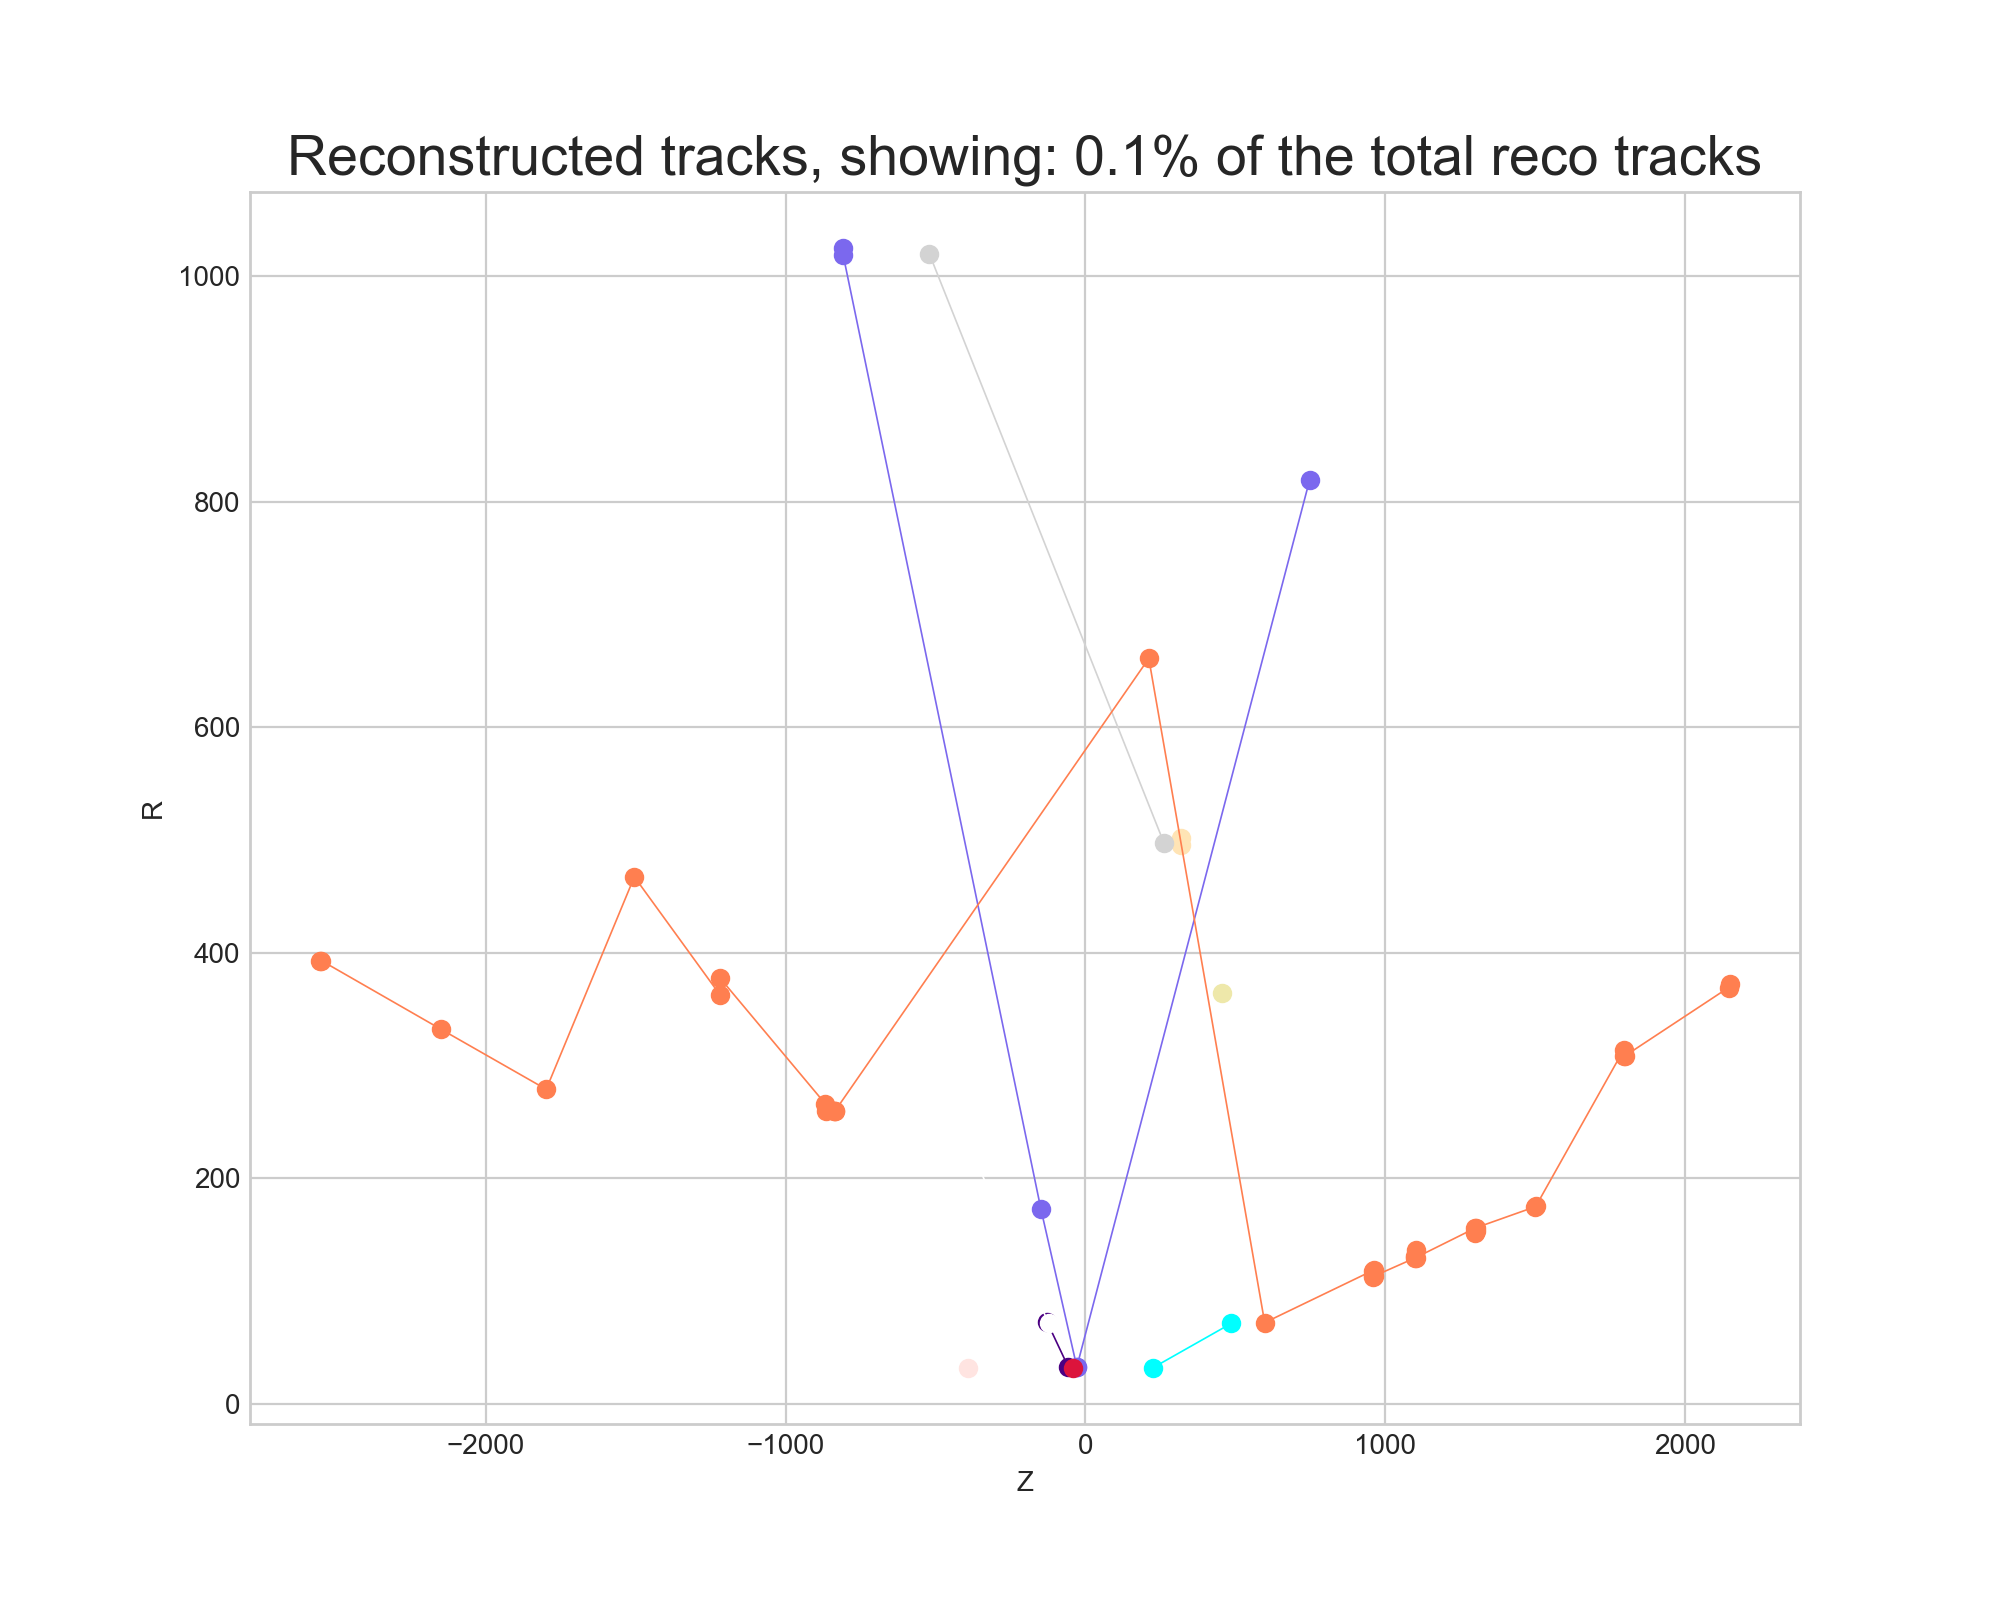

In [15]:
T_viz=10
rand_tracks=random.sample(list(np.unique(labels)), T_viz)

fig = plt.figure(figsize=(10,8))
for i in rand_tracks:
    df_plot=df_data.ix[np.where(labels==i)[0]].sort_values(by=['z'])
    plt.plot(df_plot.z,df_plot.r,"-o",c=colors[int(i)%len(colors)],linewidth=0.6)
plt.xlabel("Z")
plt.ylabel("R")
plt.title("Reconstructed tracks, showing: "+str(100*round(T_viz/float(len(np.unique(labels))),3))+"% of the total reco tracks",fontsize=20)
plt.show()


<IPython.core.display.Javascript object>


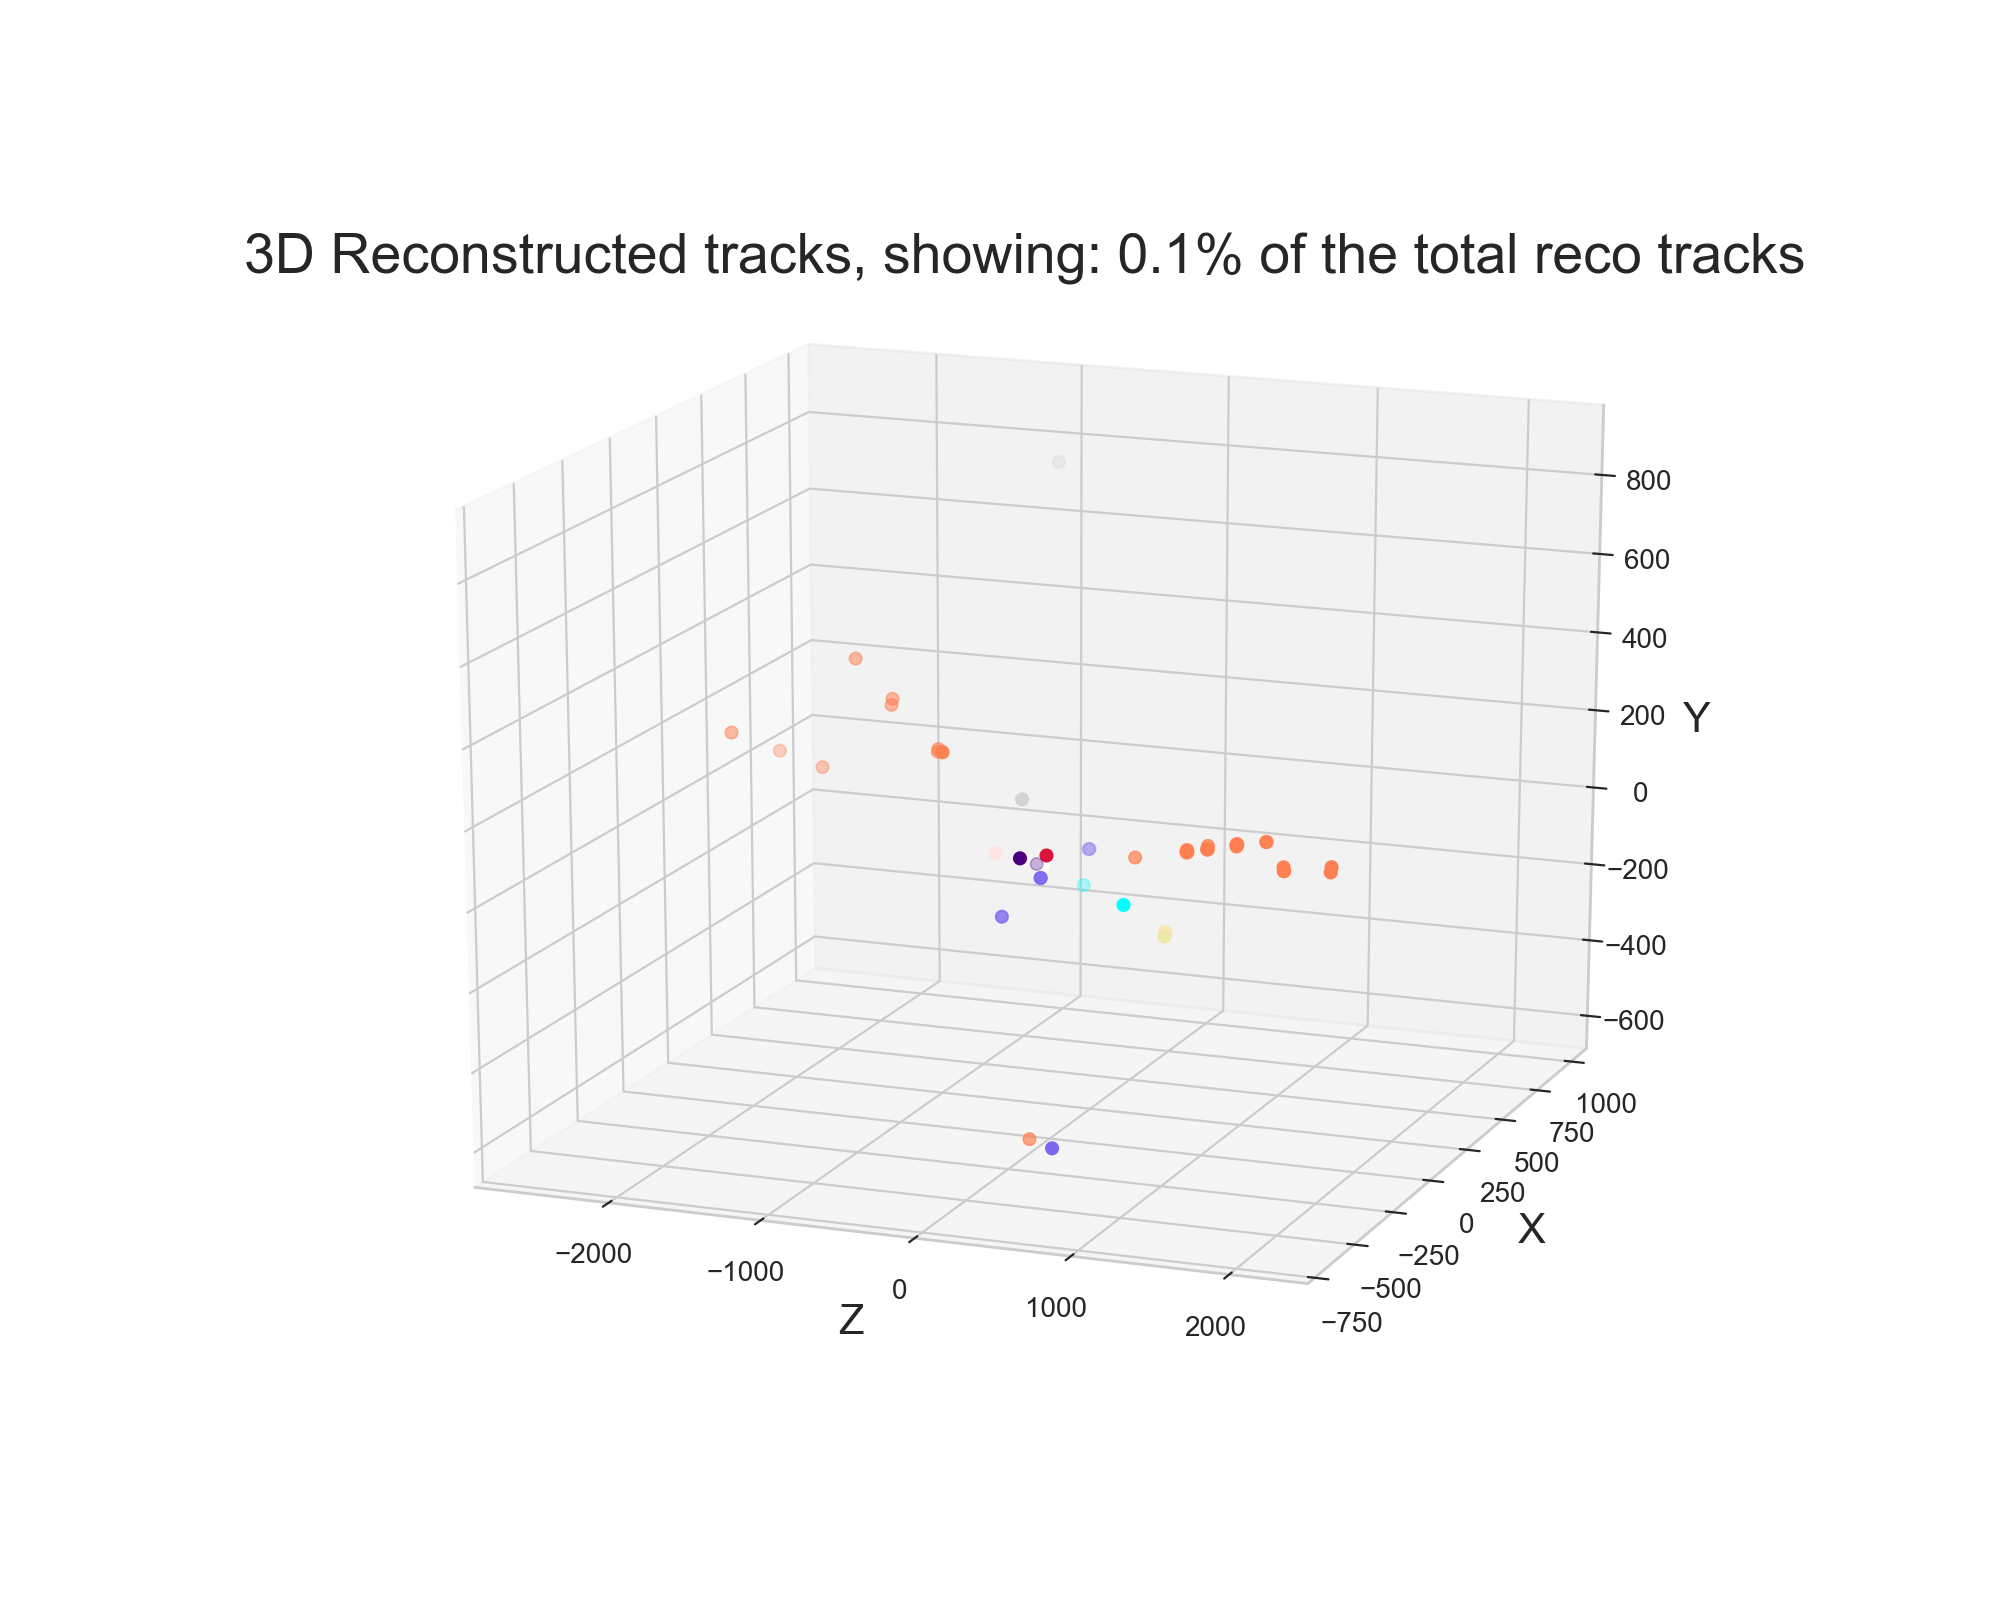

In [17]:
#3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax = fig.add_subplot(111, projection='3d')
for i in rand_tracks:
    df_plot=df_data.ix[np.where(labels==i)[0]].sort_values(by=['z'])
    ax.scatter(df_plot.z,df_plot.x,df_plot.y,"-o",c=colors[int(i)%len(colors)],linewidth=0.6)
plt.title("3D Reconstructed tracks, showing: "+str(100*round(T_viz/float(len(np.unique(labels))),3))+"% of the total reco tracks",fontsize=20)
ax.set_xlabel('Z',fontsize=15)
ax.set_ylabel('X',fontsize=15)
ax.set_zlabel('Y',fontsize=15)
plt.show()


In [10]:
event_id=np.ones(len(tracks.values))*int(prefix[-2:])
sol_df=pd.read_csv("../../example_standard/solution.csv")
tracks["weight"]=sol_df.loc[sol_df.event_id==int(prefix[-2:])].weight.values
tracks["particle_id"]=truth.particle_id.values
tracks["event_id"]=event_id


In [11]:
#visualizing the dataset
tracks.head()

hit_id  track_id    weight         particle_id  event_id
0       1      4087  0.031890  598979781232427008       0.0
1       2      4085  0.047443  702562984978808832       0.0
2       3      4062  0.017308  193658632267628544       0.0
3       4      4090  0.025087  810653224326397952       0.0
4       5      4090  0.000000                   0       0.0

## 4) Scoring online

In [12]:
#simple score Ajusted Rand Index 

print ("simple score: ",adjusted_rand_score(labels,truth.particle_id.values))
print ("custom 3D score: ")
print ("     ",score_dataset(tracks))

simple score:  0.002786626095995242
custom 3D score: 
processing event 0.0
score mean:   0.008300
score median: 0.008300
score stddev: 0.000000
      None


# ### Warning :  Memory Intensive Cell ###
## 6) Demo for multiple events

### 6.1) Computing solution and storing

In [44]:
#For every event : load, cluster, store labels
#Restart from scratch

N_pre_cluster=5
first_event=True
for event_id in range(N):
    #Loading even
    prefix="event0000000"+str("%02d" % (event_id,))
    print ("Now reading event ",path2data+prefix)
    #DR dont think we need the truth there
    hits, particles, truth=trackml.dataset.load_event(path2data+prefix)
    df_data=pd.merge(truth, pd.DataFrame(hits), on =['hit_id']).ix[:,["hit_id","particle_id","x","y","z"]]
    df_data=df_data.ix[:,["hit_id","particle_id","x","y","z"]]
    #adding the R = sqrt(x^2+y^2) column 
    df_data['r'] = df_data.apply(lambda hit: np.sqrt(hit['x']**2 + hit['y']**2), axis=1)
    #3D projection - preclustering
    print ("... compute pre-label ")


    pre_labels = KMeans(n_clusters=N_pre_cluster).fit_predict(list(df_data.ix[:,["r","z"]].values))
    #agglomerative clustering
    labels=np.zeros(len(df_data))
    for i in np.unique(pre_labels):
        idx_clus=np.where(pre_labels==i)[0]
        clus=df_data.ix[idx_clus,["x","y","z"]]
        print ("... clustering in region ",i)
        labels[idx_clus]=cluster_hits2tracks(clus)
    print ("...saving solution file:",prefix+"-solution.csv")

    tracks=pd.DataFrame(np.column_stack((range(1,len(labels)+1),labels)),columns=["hit_id","track_id"]).astype(int)
    event_id=np.ones(len(tracks.values))*event_id
    weighted = weight_hits(truth, particles)
    tracks["weight"]=weighted['weight']
    tracks["event_id"]=event_id
    tracks["particle_id"]=truth.particle_id.values
    if first_event:
            tracks.to_csv("solution.csv", mode='w', index=False)
            first_event = False
    else:
            tracks.to_csv("solution.csv", mode='a', index=False, header=False)

    


Now reading event  ../../example_standard/dataset/event000000000
... compute pre-label 
... clustering in region  0
... clustering in region  1
... clustering in region  2
... clustering in region  3
... clustering in region  4
...saving solution file: event000000000-solution.csv
Now reading event  ../../example_standard/dataset/event000000001
... compute pre-label 
... clustering in region  0
... clustering in region  1
... clustering in region  2
... clustering in region  3
... clustering in region  4
...saving solution file: event000000001-solution.csv


### 6.2) Scoring solution

In [46]:
#For every stored solution : load,score
labels_from_file=pd.read_csv("solution.csv")
for event_id,event in labels_from_file.groupby("event_id"):
    #load truth for scoring
    #hits, particles, truth=trackml.dataset.load_event(path2data+prefix)
    #truth_labels=truth['particle_id']
    print ("event "+str(event_id))
    print ("simple score: ",round(adjusted_rand_score(event.track_id,event.particle_id),3))
    print ("3D mean score :  ")
    score=score_dataset(event)


event 0.0
simple score:  0.003
3D mean score :  
processing event 0.0
score mean:   0.009399
score median: 0.009399
score stddev: 0.000000
event 1.0
simple score:  0.003
3D mean score :  
processing event 1.0
score mean:   0.014378
score median: 0.014378
score stddev: 0.000000
